In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression #로지스틱 회귀
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
import tensorflow as tf
from tensorflow.keras import layers
from catboost import Pool,CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 10000)

In [2]:
# 인덱스 설정
tmp_train=pd.read_csv("C:/Users/wnrrh/desktop/dacon/Jobcare_data/train.csv").set_index(keys='id')
tmp_test=pd.read_csv("C:/Users/wnrrh/desktop/dacon/Jobcare_data/test.csv").set_index(keys='id')
d_code=pd.read_csv("C:/Users/wnrrh/desktop/dacon/Jobcare_data/속성_D_코드.csv").set_index(keys='속성 D 코드')
h_code=pd.read_csv("C:/Users/wnrrh/desktop/dacon/Jobcare_data/속성_H_코드.csv").set_index(keys='속성 H 코드')
l_code=pd.read_csv("C:/Users/wnrrh/desktop/dacon/Jobcare_data/속성_L_코드.csv").set_index(keys='속성 L 코드')

# EDA

In [3]:
tmp_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1


In [4]:
len(tmp_train[tmp_train['target']==1])

250845

target 값은 0, 1 균등히 분포

In [5]:
# 사용자 번호
print(len(tmp_train['person_rn'].unique()))
# 50만개 중 30만개의 사용자 번호

# 컨텐츠번호
len(tmp_train['contents_rn'].unique())
# 50만개 중 약 28만개의 다른 컨텐츠가 있음

300177


283359

-- > 생각보다 같은 사용자와 컨텐츠가 많음을 의미

In [6]:
print(tmp_train['person_prefer_f'].unique())
print(tmp_train['person_prefer_g'].unique())

[1]
[1]


-------------------> 전처리 단계에서 삭제시켜도 될 컬럼들

아래부터는 회원 선호 속성 a와 a의 하위 속성을 3등분으로 만들어서 컨텐츠 a의 속성과 매칭을 시키기 위해 시각화를 해서 파악

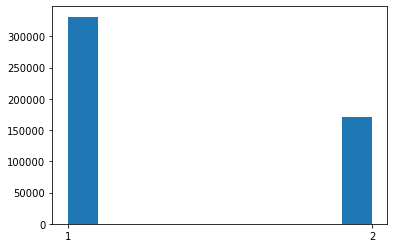

142560

In [8]:
plt.xticks([1, 2])
plt.hist(tmp_train['person_attribute_a'])
plt.show()

len(tmp_train[tmp_train['person_attribute_a'] == 1])
len(tmp_train[tmp_train['person_attribute_a'] == 2])

len(tmp_train.loc[(tmp_train['person_attribute_a_1'] == 0) | (tmp_train['person_attribute_a_1'] == 1) ])
len(tmp_train.loc[(tmp_train['person_attribute_a_1'] == 3) | (tmp_train['person_attribute_a_1'] == 4) | (tmp_train['person_attribute_a_1'] == 2)])

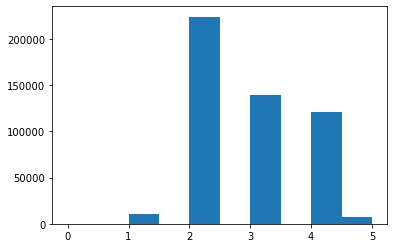

In [9]:
plt.xticks([0,1,2,3,4,5])
plt.hist(tmp_train['person_attribute_b'])
plt.show()

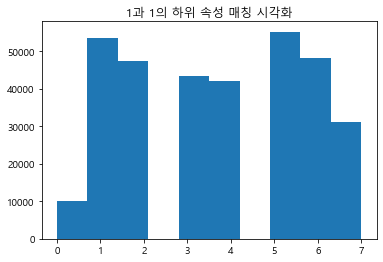

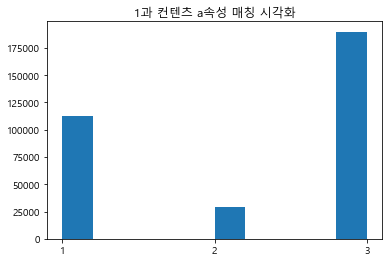

In [10]:
plt.rcParams['font.family'] = 'Malgun Gothic'
# '1'과 '1'의 하위 속성 매칭 시각화
data_a1 = tmp_train['person_attribute_a_1'][tmp_train['person_attribute_a'] == 1]
plt.xticks(np.arange(8))
plt.hist(data_a1)
plt.title('1과 1의 하위 속성 매칭 시각화')
plt.show()


# '1'과 컨텐츠 a속성 매칭 시각화
condata_a1 = tmp_train['contents_attribute_a'][tmp_train['person_attribute_a'] == 1]
plt.xticks([1, 2, 3])
plt.hist(condata_a1)
plt.title('1과 컨텐츠 a속성 매칭 시각화')
plt.show()

# 1은 2와 달리 0이 젤 낮고, 나머지 비슷
# 1은 컨텐츠 선호의 1, 3을 2에비해 좋아함 

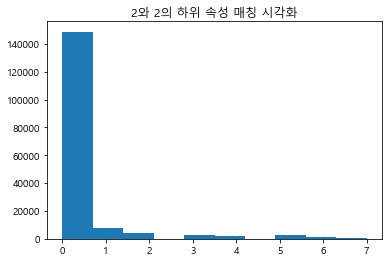

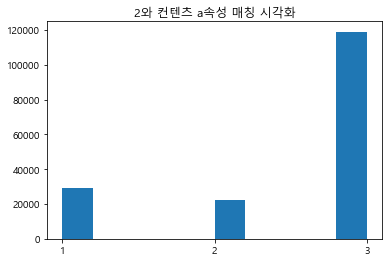

(148678,)


(170691,)

In [11]:
# '2'과 '2'의 하위 속성 매칭 시각화
data_a2 = tmp_train['person_attribute_a_1'][tmp_train['person_attribute_a'] == 2]
plt.xticks(np.arange(8))
plt.hist(data_a2)
plt.title('2와 2의 하위 속성 매칭 시각화')
plt.show()

# '2'와 컨텐츠 a속성 매칭 시각화
condata_a1 = tmp_train['contents_attribute_a'][tmp_train['person_attribute_a'] == 2]
plt.xticks([1, 2, 3])
plt.hist(condata_a1)
plt.title('2와 컨텐츠 a속성 매칭 시각화')
plt.show()

condata__a1 = tmp_train['contents_attribute_a']
condition = (tmp_train['person_attribute_a'] == 2) & (tmp_train['person_attribute_a_1'] == 0)
k = tmp_train['contents_attribute_a'][condition]

print(k.shape)
data_a2.shape

# 2는 0이 존나많음
# 컨텐츠 속성의 3을 존나 좋아함

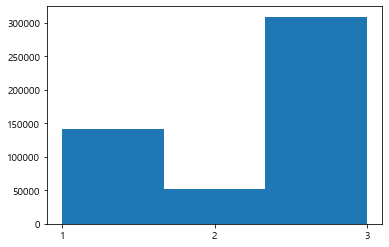

In [12]:
# 컨텐츠 속성 a
plt.xticks([1, 2, 3])
plt.hist(tmp_train['contents_attribute_a'], bins = 3)
plt.show()

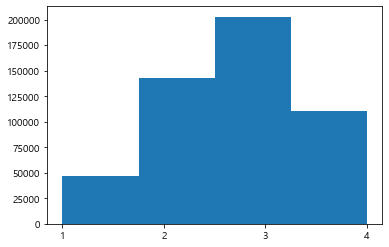

In [13]:
# 시간대별로 나눈 컬럼
tmp_train['Quarter_Day'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 1 if 0 <= x <= 6 else(2 if 6<x<=12 else(3 if 12<x<=18 else 4))).astype('int64')
#tmp_train['second_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 2 if 6 < x <= 12).astype('int64')
#tmp_train['third_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 12 < x <= 18).astype('int64')
#tmp_train['last_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 18 < x <= 24).astype('int64')
#tmp_train['first_time'].head(100)
plt.xticks([1,2,3,4])
plt.hist(tmp_train['Quarter_Day'],bins=4)
plt.show()
#  1. 개수 파악
#  2. EDA 필요

# 시간대 / 요일과 target 간 연관성

C:\Users\wnrrh\AppData\Local\Temp/ipykernel_11440/1372430289.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=np.array([[len(tmp_train[tmp_train['Quarter_Day']==i][tmp_train['target']==j]) for i in range(1,5)] for j in range(2)])


([<matplotlib.axis.XTick at 0x1dd0912a4c0>,
 [Text(0, 0, 'target_0'), Text(1, 0, 'target_1')])

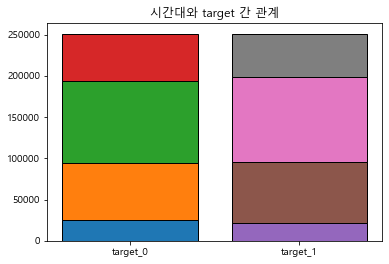

In [14]:
data=np.array([[len(tmp_train[tmp_train['Quarter_Day']==i][tmp_train['target']==j]) for i in range(1,5)] for j in range(2)])
idx=np.array([0,1])
plt.title('시간대와 target 간 관계')
for j in range(2):
    for i in range(4):
        plt.bar(np.array([j]),data[j][i],bottom=np.sum(data[j][:i],axis=0),edgecolor='black')
plt.xticks(idx,['target_0','target_1'])

In [15]:
import matplotlib.colors as mcolors
tmp_tmp=tmp_train.copy()
tmp_tmp['contents_open_dt']=tmp_tmp['contents_open_dt'].astype('datetime64[ns]').dt.dayofweek

C:\Users\wnrrh\AppData\Local\Temp/ipykernel_11440/1327594220.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=np.array([[len(tmp_tmp[tmp_tmp['contents_open_dt']==i][tmp_tmp['target']==j]) for i in range(7)] for j in range(2)])


([<matplotlib.axis.XTick at 0x1dd09199130>,
 [Text(0, 0, 'target_0'), Text(1, 0, 'target_1')])

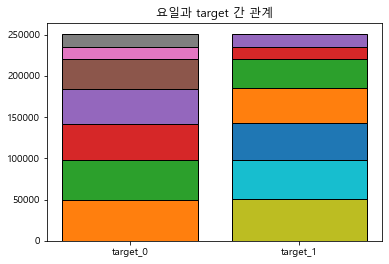

In [16]:
data=np.array([[len(tmp_tmp[tmp_tmp['contents_open_dt']==i][tmp_tmp['target']==j]) for i in range(7)] for j in range(2)])
idx=np.arange(2)
plt.bar(idx,0)
plt.title('요일과 target 간 관계')
for j in range(2):
    for i in range(7):
        plt.bar(np.array([j]),data[j][i],bottom=np.sum(data[j][:i],axis=0),edgecolor='black')
plt.xticks(idx,['target_0','target_1'])

In [17]:
tmp_train.isna().sum()

d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
h_m_match_yn              0
h_s_match_yn              0
person_attribute_a        0
person_attribute_a_1      0
person_attribute_b        0
person_prefer_c           0
person_prefer_d_1         0
person_prefer_d_2         0
person_prefer_d_3         0
person_prefer_e           0
person_prefer_f           0
person_prefer_g           0
person_prefer_h_1         0
person_prefer_h_2         0
person_prefer_h_3         0
contents_attribute_i      0
contents_attribute_a      0
contents_attribute_j_1    0
contents_attribute_j      0
contents_attribute_c      0
contents_attribute_k      0
contents_attribute_l      0
contents_attribute_d      0
contents_attribute_m      0
contents_attribute_e      0
contents_attribute_h      0
person_rn                 0
contents_rn               0
contents_open_dt          0
target                    0
Quarter_Day               0
dtype: int64

In [18]:
tmp_test.isna().sum()

d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
h_m_match_yn              0
h_s_match_yn              0
person_attribute_a        0
person_attribute_a_1      0
person_attribute_b        0
person_prefer_c           0
person_prefer_d_1         0
person_prefer_d_2         0
person_prefer_d_3         0
person_prefer_e           0
person_prefer_f           0
person_prefer_g           0
person_prefer_h_1         0
person_prefer_h_2         0
person_prefer_h_3         0
contents_attribute_i      0
contents_attribute_a      0
contents_attribute_j_1    0
contents_attribute_j      0
contents_attribute_c      0
contents_attribute_k      0
contents_attribute_l      0
contents_attribute_d      0
contents_attribute_m      0
contents_attribute_e      0
contents_attribute_h      0
person_rn                 0
contents_rn               0
contents_open_dt          0
dtype: int64

# DF 전처리

In [19]:
def createDF(main_df,d_code=d_code,h_code=h_code,l_code=l_code): #n:세분류,s:소분류,m:중분류,l:대분류
    main_df=main_df.copy()
#     df 복사본 만들기

    
    
    main_df["person_prefer_d_1_n"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_1_s"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_1_m"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_1_l"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df["person_prefer_d_2_n"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_2_s"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_2_m"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_2_l"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df["person_prefer_d_3_n"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_3_s"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_3_m"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_3_l"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df['person_prefer_h_1_m']=main_df['person_prefer_h_1'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_1_l']=main_df['person_prefer_h_1'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['person_prefer_h_2_m']=main_df['person_prefer_h_2'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_2_l']=main_df['person_prefer_h_2'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['person_prefer_h_3_m']=main_df['person_prefer_h_3'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_3_l']=main_df['person_prefer_h_3'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['contents_attribute_l_n']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 세분류코드"])
    main_df['contents_attribute_l_s']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 소분류코드"])
    main_df['contents_attribute_l_m']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 중분류코드"])
    main_df['contents_attribute_l_l']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 대분류코드"])
    
    main_df['contents_attribute_d_n']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df['contents_attribute_d_s']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df['contents_attribute_d_m']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df['contents_attribute_d_l']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])

    main_df['contents_attribute_h_m']=main_df['contents_attribute_h'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['contents_attribute_h_l']=main_df['contents_attribute_h'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    return main_df
    

In [20]:
createDF(tmp_train)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target,Quarter_Day,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,person_prefer_h_1_m,person_prefer_h_1_l,person_prefer_h_2_m,person_prefer_h_2_l,person_prefer_h_3_m,person_prefer_h_3_l,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,contents_attribute_h_m,contents_attribute_h_l
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1,2,275,274,274,216,369,368,297,216,369,368,297,216,316,3,398,94,368,58,1607,1606,1605,2016,275,274,274,216,422,94
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0,3,114,109,56,1,175,152,56,1,175,152,56,1,417,94,400,94,399,94,1607,1606,1605,2016,275,274,274,216,417,94
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0,4,464,463,450,377,175,152,56,1,452,451,450,377,364,48,528,250,366,48,1599,1595,1572,2016,92,91,56,1,363,48
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0,3,703,703,690,618,703,703,690,618,703,703,690,618,379,71,495,226,315,1,1607,1606,1605,2016,275,274,274,216,381,71
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0,4,275,274,274,216,369,368,297,216,369,368,297,216,483,208,481,208,480,208,1607,1606,1605,2016,275,274,274,216,381,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1,2,1192,1180,1169,926,929,928,927,926,1227,1227,1227,926,368,58,316,3,398,94,352,347,346,2006,145,123,56,1,373,58
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1,2,114,109,56,1,110,109,56,1,110,109,56,1,401,94,425,94,398,94,155,138,99,2006,114,109,56,1,425,94
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1,3,145,123,56,1,46,43,2,1,145,123,56,1,368,58,413,94,422,94,437,417,407,2006,145,123,56,1,373,58


In [22]:
def preprocessing(df:pd.DataFrame)->pd.DataFrame:
#     '->'는 Return 값이 어떤 상태인지를 명시하기 위함
    
#     회원 속성과 컨텐츠속성 매칭해서 True, False 명시
    print('--------start---------')
    df=df.copy()
#     df 복사본 만들기
    df.drop(['person_prefer_f','person_prefer_g','contents_rn','person_rn'],axis=1,inplace=True)
    #person_prefer_f,g는 값이 모두 1임
    
    
    
    print('---------mid_1----------')
    df['d_match_yn']=df['d_s_match_yn'] #d코드 매칭여부
    df['d_n_match_yn']=df['d_m_match_yn'] #d 세분류 매칭여부
    df['d_s_match_yn']=(df['person_prefer_d_1_s']==df['contents_attribute_d_s']) #d 소분류 매칭여부
    df['d_m_matck_yn']=(df['person_prefer_d_1_m']==df['contents_attribute_d_m']) #d 중분류 매칭여부
    
    df['d_2_match_yn']=(df['person_prefer_d_2']==df['contents_attribute_d'])
    df['d_2_n_match_yn']=(df['person_prefer_d_2_n']==df['contents_attribute_d_n'])
    df['d_2_s_match_yn']=(df['person_prefer_d_2_s']==df['contents_attribute_d_s'])
    df['d_2_m_match_yn']=(df['person_prefer_d_2_m']==df['contents_attribute_d_m'])
    df['d_2_l_match_yn']=(df['person_prefer_d_2_l']==df['contents_attribute_d_l'])
    
    df['d_3_match_yn']=(df['person_prefer_d_3']==df['contents_attribute_d'])
    df['d_3_n_match_yn']=(df['person_prefer_d_3_n']==df['contents_attribute_d_n'])
    df['d_3_s_match_yn']=(df['person_prefer_d_3_s']==df['contents_attribute_d_s'])
    df['d_3_m_match_yn']=(df['person_prefer_d_3_m']==df['contents_attribute_d_m'])
    df['d_3_l_match_yn']=(df['person_prefer_d_3_l']==df['contents_attribute_d_l'])
    
    df['h_match_yn']=df['h_s_match_yn']
    
    df['h_2_match_yn']=(df['person_prefer_h_2']==df['contents_attribute_h'])
    df['h_2_m_match_yn']=(df['person_prefer_h_2_m']==df['contents_attribute_h_m'])
    df['h_2_l_match_yn']=(df['person_prefer_h_2_l']==df['contents_attribute_h_l'])
    
    df['h_3_match_yn']=(df['person_prefer_h_3']==df['contents_attribute_h'])
    df['h_3_m_match_yn']=(df['person_prefer_h_3_m']==df['contents_attribute_h_m'])
    df['h_3_l_match_yn']=(df['person_prefer_h_3_l']==df['contents_attribute_h_l'])
    
    #df['a_match_yn']
    df['c_match_yn']=(df['person_prefer_c']==df['contents_attribute_c'])
    df['e_match_yn']=(df['person_prefer_e']==df['contents_attribute_e'])
    
    print('---------mid_2----------')
    
    for column in df.keys():
        if column=='contents_open_dt':
            df[column]=df[column].astype('datetime64').dt.dayofweek #0~6(0부터 월요일~)
#             dt.dayofweek 에서 dt는 접근자
        if df[column].dtypes!='datetime64':
            df[column]=df[column].astype('int64')
    df['weekend']=df['contents_open_dt'].apply(lambda x: 1 if x>=5 else 0)
    
#     주말: 1 , 평일: 0
    
#     print('---------mid_3-----------')
#     df['person_attribute_a']=df['person_attribute_a_1'].apply(lambda x: x+1)*(df['person_attribute_a'].apply(lambda x:1 if x==1 else -1 ))
#     df['contents_attribute_j']=df['contents_attribute_j'].apply(lambda x: 0 if x==1 else 10)+df['contents_attribute_j_1']
    
    print('---------mid_3----------')
    
    df['contents_attribute_k']-=1
    #df=pd.get_dummies(df,columns=['person_prefer_c','contents_attribute_i','contents_attribute_a',
    #                              'contents_attribute_j','contents_attribute_c','contents_attribute_m','contents_open_dt'])
    df.drop(['h_s_match_yn','weekend','contents_open_dt'],axis=1,inplace=True)
    print("-----------finish------------")
    
    return df

# New DF 생성하고 전처리 한 DF 지정(train, test)

In [ ]:
train_set=preprocessing(createDF(tmp_train))
test_set=preprocessing(createDF(tmp_test))

Train, Test set columns

In [ ]:
train_set.keys()

In [ ]:
test_set.keys()

In [ ]:
# Column 설정
key_list=list(train_set.keys())
target_idx=key_list.index('target')
# train, test Split
y_train=train_set['target']
x_train=train_set[key_list[:target_idx]+key_list[target_idx+1:]]

In [ ]:
y_train

In [ ]:
x_train

# Modeling

In [ ]:
#캣부스트(CatBoost)
#cat_features=x_train.columns[x_train.nunique()>2].to_list()
is_holdout=False
# 이건뭐임?

cv=KFold(n_splits=5,
        shuffle=True, random_states=123)
cat_features=x_train.columns.to_list()
scores=[]
models=[]

for train_idx,val_idx in cv.split(x_train):
    print('='*30)
    preds=[]
    
    model=CatBoostClassifier(iterations=3000,
                             task_type='GPU',
                             eval_metric='F1',
                             cat_features=cat_features,
                             one_hot_max_size=4)
    
    model.fit(x_train.iloc[train_idx],y_train[train_idx],
              eval_set=[(x_train.iloc[val_idx],y_train[val_idx])],
              early_stopping_rounds=100,
              verbose=100)
    
    models.append(model)
    scores.append(model.get_best_score()['validation']['F1'])
    if is_holdout:
        break

print(scores)
print(np.mean(scores))

In [ ]:
threshold=0.34
pred_list=[]
scores_2=[]

for i,(train_idx,val_idx) in enumerate(cv.split(x_train)):
    pred=models[i].predict_proba(x_train.iloc[val_idx])[:,1]
    pred=np.where(pred>=threshold,1,0)
    score=f1_score(y_train[val_idx],pred)
    scores_2.append(score)
    pred=models[i].predict_proba(test_set)[:,1]
    pred_list.append(pred)

print(scores_2)
print(np.mean(scores_2))

In [ ]:
#preds=model.predict(test_set) # catboost 말고

preds=np.mean(pred_list,axis=0) # catboost
preds=np.where(preds>=threshold,1,0) # catboost

In [ ]:
# 제출
submission=pd.read_csv('sample_submission.csv')
submission['target']=preds.round()
submission.to_csv('D:/Users/user/Desktop/submission.csv',index=False)